# FEATURE ENGINERING GLOBAL

### En este script se pretende verificar que las variables de fecha esten correctas, ver la correlación de las variables y definir la variable objetivo.

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant  # ← ESTA ERA LA QUE FALTABA

In [60]:
df = pd.read_csv("../data/interim/df_clean_features.csv")


## Verificar variables de fecha

In [61]:
# Variables no detectadas como fechas

posibles_fechas = []

for col in df.columns:
    if df[col].dtype == 'object':
        try:
            pd.to_datetime(df[col].dropna().sample(5), errors='raise')
            posibles_fechas.append(col)
        except:
            continue

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("Columnas detectadas como fechas:")
print(posibles_fechas)

Columnas detectadas como fechas:
['fecha_primer_producto', 'fecha_segundo_producto', 'mes_mas_compras.x', 'mes_mayor_monto.x']


In [62]:
for col in posibles_fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(df[posibles_fechas].dtypes)
print(df[posibles_fechas].head())

fecha_primer_producto     datetime64[ns]
fecha_segundo_producto    datetime64[ns]
mes_mas_compras.x         datetime64[ns]
mes_mayor_monto.x         datetime64[ns]
dtype: object
  fecha_primer_producto fecha_segundo_producto mes_mas_compras.x  \
0            2021-06-01             1900-01-01        2023-03-01   
1            2021-09-11             2021-10-16        2023-06-01   
2            2021-02-07             2021-07-25        2023-01-01   
3            2021-11-02             1900-01-01        2023-12-01   
4            2022-06-08             2022-08-05        2023-11-01   

  mes_mayor_monto.x  
0        2023-12-01  
1        2023-06-01  
2        2023-01-01  
3        2023-12-01  
4        2023-03-01  


In [63]:
#convertir en tipo fecha

fecha_cols = [col for col in df.columns if "fecha" in col.lower()]
for col in fecha_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df[fecha_cols].head()

,fecha_primer_producto,fecha_segundo_producto
0,2021-06-01,1900-01-01
1,2021-09-11,2021-10-16
2,2021-02-07,2021-07-25
3,2021-11-02,1900-01-01
4,2022-06-08,2022-08-05


# Variable objetivo IMPORTANTE

## No es necesario hacer una variable se va a escoger insurance como variable objetivo

# Análisis de correlación

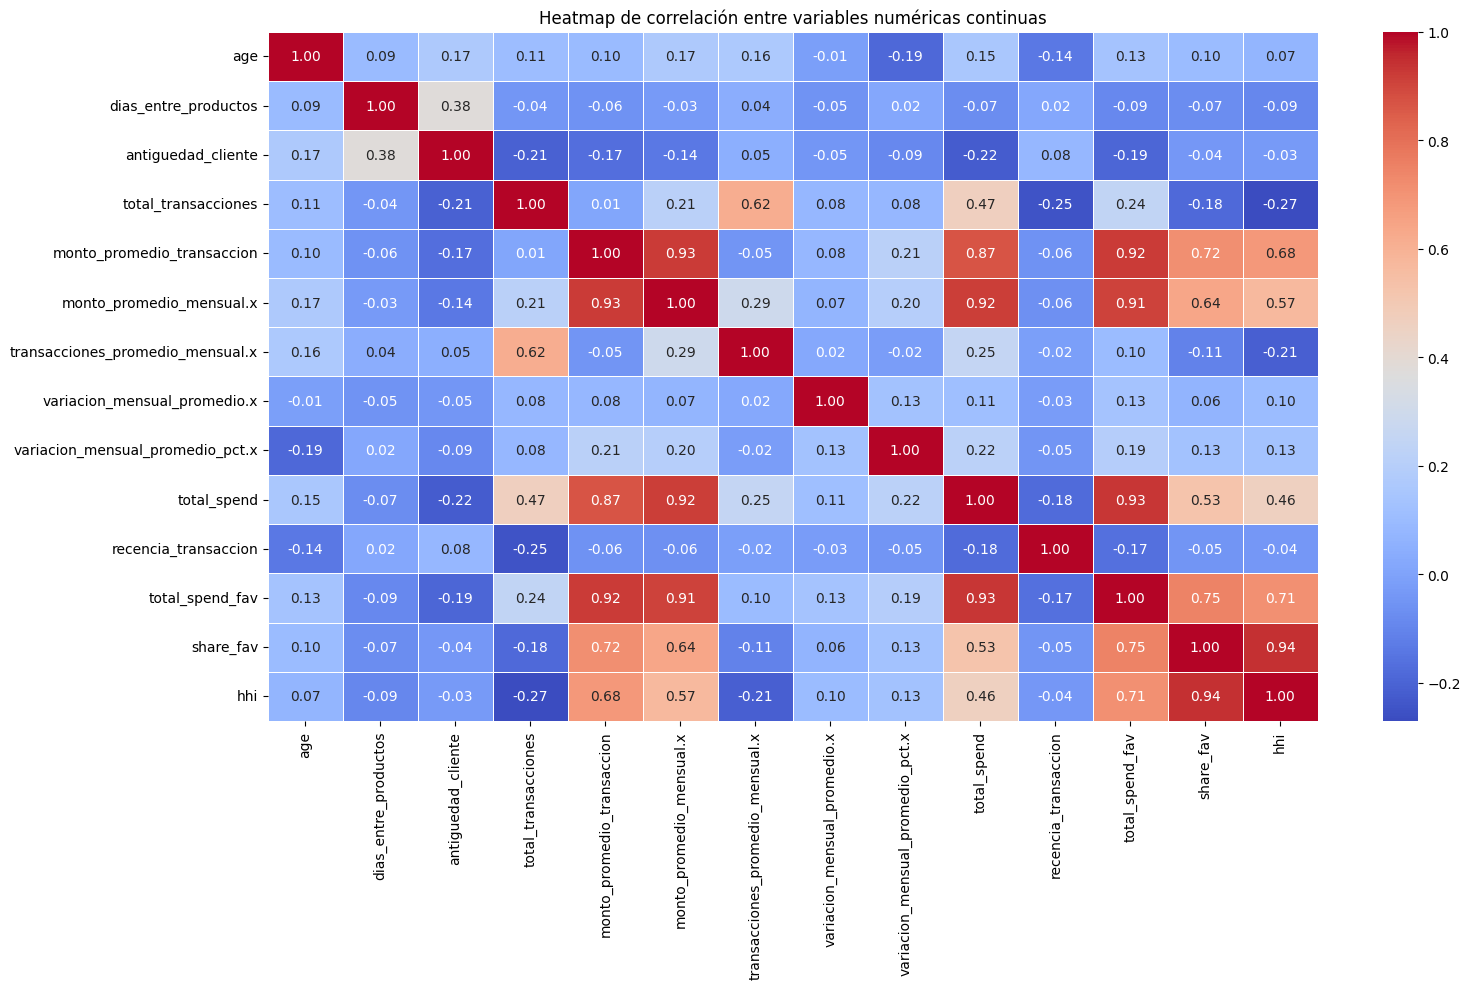

                            Variable         VIF
0                              const  289.308340
10                       total_spend   67.991098
6           monto_promedio_mensual.x   59.743131
5         monto_promedio_transaccion   39.436096
12                   total_spend_fav   39.065034
14                               hhi   12.948370
13                         share_fav   12.133946
4                total_transacciones   10.097715
7   transacciones_promedio_mensual.x    8.122448
3                 antiguedad_cliente    1.378885
2               dias_entre_productos    1.215362
1                                age    1.186664
11              recencia_transaccion    1.166270
9   variacion_mensual_promedio_pct.x    1.159112
8       variacion_mensual_promedio.x    1.073107


In [64]:
#Analisis de correlaciones con heatmap

numerical_cols = df.select_dtypes(include='number').columns
numerical_continuas = [
    col for col in numerical_cols if df[col].nunique() > 10 and not col.startswith("Unnamed")
]

corr_matrix = df[numerical_continuas].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap de correlación entre variables numéricas continuas")
plt.tight_layout()
plt.show()


#Calculo VIF

df_vif = df[numerical_continuas].dropna().copy()

X_vif = add_constant(df_vif)

vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values(by="VIF", ascending=False)

print(vif_df)

### Analisis 

Se puede observar alta correlacion entre:

-monto_promedio_transaccion vs monto_promedio_mensual.x
-monto_promedio_mensual.x vs total_spend
-total_spend_fav vs monto_promedio_mensual.x
-share_fav vs total_spend_fav
-share_fav vs hhi

Las menos coreelacionadas son edad, recencia, dia entre productos y variacion mensual

En el analisis de colinealidad nos muestra que total spend, monto promedio mensual, monto promedio transaccion, total spen, hhi y share fav. Es por ellos que se seleccionar las mas correlacionas y con alta colinealidad para eliminarlas



In [65]:
variables_a_eliminar = [
    "total_spend",
    "monto_promedio_mensual.x",
    "monto_promedio_transaccion",
    "hhi",
    "share_fav",
    "total_transacciones"
]

df_reduced = df.drop(columns=variables_a_eliminar, errors="ignore")


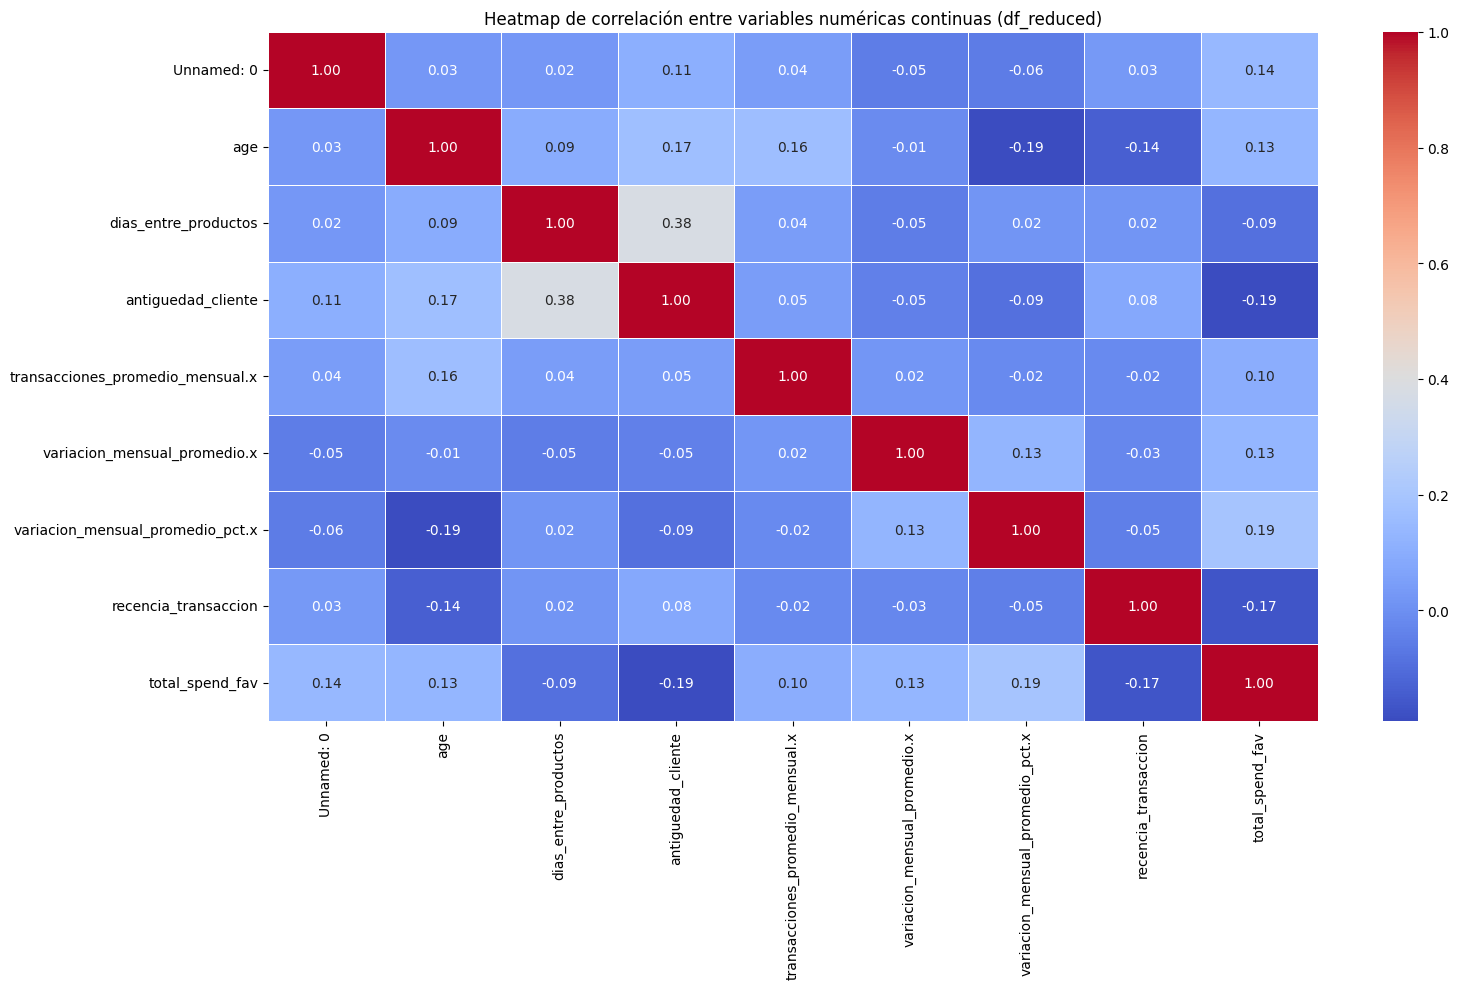


--- MATRIZ DE VIF (df_reduced) ---
                           Variable        VIF
0                             const  53.520532
4                antiguedad_cliente   1.268759
9                   total_spend_fav   1.202498
3              dias_entre_productos   1.177217
2                               age   1.160572
7  variacion_mensual_promedio_pct.x   1.118505
1                        Unnamed: 0   1.054060
8              recencia_transaccion   1.053440
5  transacciones_promedio_mensual.x   1.037743
6      variacion_mensual_promedio.x   1.035898


In [66]:
numerical_cols = df_reduced.select_dtypes(include='number').columns
numerical_continuas = [
    col for col in numerical_cols if df_reduced[col].nunique() > 10 and col != "target"
]

corr_matrix = df_reduced[numerical_continuas].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap de correlación entre variables numéricas continuas (df_reduced)")
plt.tight_layout()
plt.show()

# --- 2. Cálculo de VIF con df_reduced ---
print("\n--- MATRIZ DE VIF (df_reduced) ---")
df_vif = df_reduced[numerical_continuas].dropna().copy()
X_vif = add_constant(df_vif)

vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values(by="VIF", ascending=False)

print(vif_df)

In [ ]:
#En el nuevo data set ya no hay alta correlación y colinealidad

In [41]:
# Guardar dataset 
df_reduced.to_csv("../data/interim/df_features_general.csv", index=False)